### TO DO
 - Add WOA2013 panel to plot
 

In [4]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
client = Client('tcp://10.0.64.12:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


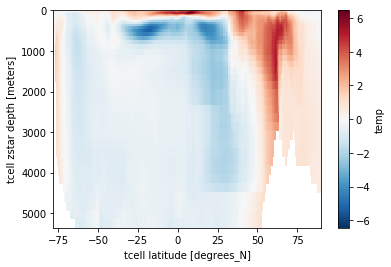

In [6]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

zonal_temp_10 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('xt_ocean').mean('time')
temp_WOA13_10 = cc.get_nc_variable('woa13/10', 'woa13_ts_??_mom10.nc', 'temp').mean('GRID_X_T').mean('time')
temp_anom_10 = zonal_temp_10 - temp_WOA13_10.values - 273.15
temp_anom_10.load()

IPython.display.clear_output()

temp_anom_10.plot(yincrease=False)

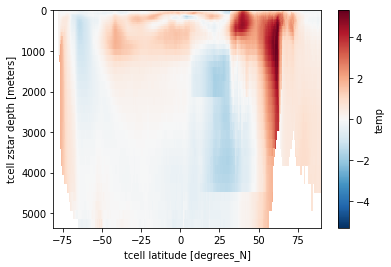

In [7]:
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
surface_temp_025 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('xt_ocean').mean('time')
temp_WOA13_025 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'temp').mean('GRID_X_T').mean('time')
temp_anom_025 = surface_temp_025 - temp_WOA13_025.values - 273.15

temp_anom_025.load()

IPython.display.clear_output()

temp_anom_025.plot(yincrease=False)

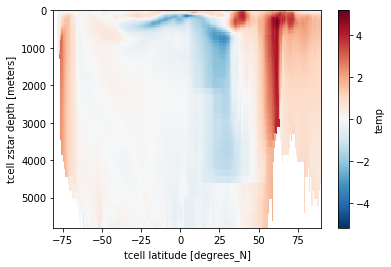

In [8]:
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
zonal_temp_01 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=-12,
                        time_units=time_units, offset=offset).mean('xt_ocean').mean('time')
temp_WOA13_01 = cc.get_nc_variable('woa13/01', 'woa13_ts_??_mom01.nc', 'temp').mean('GRID_X_T').mean('time')
temp_anom_01 = zonal_temp_01 - temp_WOA13_01.values - 273.15
temp_anom_01.load()
IPython.display.clear_output()

temp_anom_01.plot(yincrease=False)

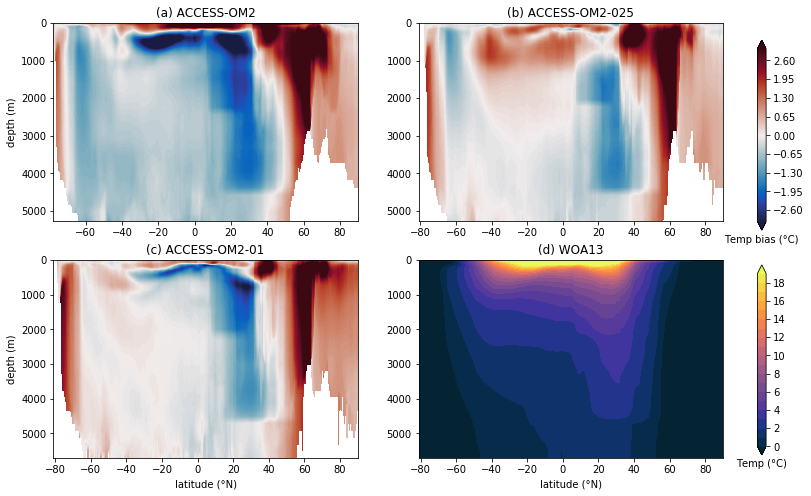

In [13]:
plt.figure(figsize=(12,8))
clev=np.arange(-3,3.01,0.05)
    
plt.subplot(221)
p1=temp_anom_10.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(a) ACCESS-OM2')

plt.subplot(222)
p1=temp_anom_025.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')

plt.subplot(223)
p1=temp_anom_01.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('depth (m)')
plt.title('(c) ACCESS-OM2-01')

plt.subplot(224)
p4=temp_WOA13_01.plot.contourf(cmap=cm.cm.thermal,levels=np.arange(0,20,1),yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('')
plt.title('(d) WOA13')

#plt.subplots_adjust(left=0.08,right=0.92)
#ax = plt.gca()
#tmp = ax.get_position(original=True)
#tmp.x0 = tmp.x0 + 0.23
#tmp.x1 = tmp.x1 + 0.23
#print(tmp)
#ax.set_position(tmp)

ax1 = plt.axes([0.94,0.52,0.01,0.33])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Temp bias (°C)')


ax2 = plt.axes([0.94,0.13,0.01,0.33])
cb = plt.colorbar(p4,cax=ax2,orientation='vertical')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Temp (°C)')

savefigure('zonal_temp_bias')